In [2]:
from torch import nn
import torch
import matplotlib.pyplot as plt
from mapsgan.toymodules import ToyGenerator, Encoder
from mapsgan import TrajectoryDataset, experiments, data_loader
from mapsgan.utils import get_dtypes, make_mlp, get_noise, relative_to_abs
long_dtype, dtype = get_dtypes()

In [3]:
class BicycleEncoder(nn.Module):
    """Encoder, part of both Generator and Discriminator.

        Args:
            embedding_dim (int): Output dim of embedding (2 -> embedding_dim, via Linear layer).
            h_dim (int): Hidden dim of the LSTM (embedding_dim -> h_dim).
            num_layers (int): Number of stacked lstms.
            dropout (float): Specifies dropout in the lstm layer.
            z_dim (int): Dimension of noise input.

        Attributes:
            embedding_dim (int): Output dim of linear layer: 2 -> embedding_dim.
            h_dim (int): Hidden dim of the LSTM: embedding_dim -> h_dim.
            num_layers (int): Number of stacked lstms.
            embedding (nn.Linear): Embeds x and y coordinates into embedding_dim dimensions.
            encoder (nn.LSTM): Encodes trajectory information.

    """

    def __init__(self, embedding_dim=64, h_dim=64, z_dim=8, num_layers=1, dropout=0.0):
        super(BicycleEncoder, self).__init__()

        self.h_dim = h_dim
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = nn.Linear(2, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, h_dim, num_layers, dropout=dropout)
        self.fc = nn.Linear(h_dim*num_layers, z_dim)
        self.fclogvar = nn.Linear(h_dim*num_layers, z_dim)

    def init_hidden(self, batch):
        return (torch.zeros(self.num_layers, batch, self.h_dim).type(dtype),
                torch.zeros(self.num_layers, batch, self.h_dim).type(dtype))

    def _forward(self, xy_in):
        """ Forward function of the Trajectory Encoder.

            Args:
                xy_in (tensor): Tensor of shape (in_len, batch_size, 2).

            Returns:
                tensor: Tensor of shape (self.num_layers, batch, self.h_dim).

            Note: The batchsize must not be static.
        """
        # Encode observed Trajectory
        batch = xy_in.size(1)
        xy_in_embedding = self.embedding(xy_in.contiguous().view(-1, 2))
        xy_in_embedding = xy_in_embedding.view(-1, batch, self.embedding_dim)
        state_tuple = self.init_hidden(batch)
        output, state = self.encoder(xy_in_embedding, state_tuple)
        hidden = state[0].view(-1, self.h_dim)
        return self.fc(hidden), self.fclogvar(hidden)
    
    def forward(self, xy_in):
        mu, logvar = self._forward(xy_in)
        std = logvar.mul(0.5).exp_()
        eps = self.get_z_random(std.size(0), std.size(1))
        z = eps.mul(std).add_(mu)
        return z, mu, logvar
    
    def get_z_random(self, batch_size, nz, random_type='gauss'):
        if random_type == 'uni':
            z = torch.rand(batch_size, nz) * 2.0 - 1.0
        elif random_type == 'gauss':
            z = torch.randn(batch_size, nz)
        return z

In [4]:
experiment = experiments.ETH() # we store filepaths and arguments in here
experiment.init_default_args() # those are some default SGAN parameters used in SGANSolver
dataset, trainloader = data_loader(in_len=8, out_len=12, batch_size=64, num_workers=1, path=experiment.train_dir,
                                  shuffle = True)

In [64]:
dl = iter(trainloader)
data = next(dl)
xy_in = data['xy_in']
xy_out = data['xy_out']
dxdy_in = data['dxdy_in']
seq_start_end = data['seq_start_end']

Process Process-4:
Traceback (most recent call last):
  File "/home/j.lappalainen/anaconda3/envs/mapsgan/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/j.lappalainen/anaconda3/envs/mapsgan/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/j.lappalainen/anaconda3/envs/mapsgan/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/j.lappalainen/anaconda3/envs/mapsgan/lib/python3.7/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/j.lappalainen/anaconda3/envs/mapsgan/lib/python3.7/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/j.lappalainen/anaconda3/envs/mapsgan/lib/python3.7/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/j.lappala

In [9]:
encoder = BEncoder()

In [10]:
z, mu, logvar = encoder(xy_out)

### Train cVAE

In [8]:
lambda_kl = 1
encoder = BicycleEncoder()
optim = torch.optim.Adam(encoder.parameters(), lr=0.01)

In [9]:
loss = []
for batch in trainloader:
    dxdy_out = batch['dxdy_out']
    z, mu, logvar = encoder(dxdy_out)
    optim.zero_grad()
    loss_kl = torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * (-0.5 * lambda_kl)
    print(f'{loss_kl}')
    loss_kl.backward()
    optim.step()
    loss.append(loss_kl.detach().numpy())

51.452484130859375
191.5106964111328
8.489622116088867
43.0538444519043
31.775495529174805
21.591840744018555
8.733455657958984
6.406682968139648
3.904054641723633
2.5728697776794434
2.2681500911712646
2.038787364959717
1.329505443572998
1.1939587593078613
1.3068468570709229
0.8364225029945374
0.937584400177002
1.0408902168273926
0.6219902038574219
0.7844846844673157
0.6705986261367798
0.5493132472038269
0.4506416320800781
0.5120222568511963
0.5035470128059387
0.39893215894699097
0.43815696239471436
0.23011276125907898
0.19734206795692444
0.14398068189620972
0.15008223056793213
0.16800245642662048
0.14506620168685913
0.10244834423065186
0.09922847151756287
0.10513067245483398
0.10548347234725952
0.1618305742740631
0.11634749174118042
0.1226014792919159
0.09413981437683105
0.10154807567596436
0.09042298793792725
0.02418452501296997


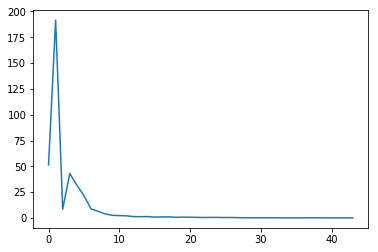

In [10]:
plt.plot(loss)

### Train cLR

In [5]:
lambda_z = 1
z_dim = 8
encoder = BicycleEncoder()
generator = ToyGenerator(in_len=8, out_len=12, z_dim=z_dim)
optim = torch.optim.SGD(encoder.parameters(), lr=0.001)
optimG = torch.optim.Adam(generator.parameters(), lr = 0.001)
criterion = nn.L1Loss()

In [6]:
loss = []
for epoch in range(10):
    print(f'Epoch {epoch}')
    for batch in trainloader:
        xy_in = batch['xy_in']
        dxdy_in = batch['dxdy_in']
        seq_start_end = batch['seq_start_end']
        z_random = encoder.get_z_random(xy_in.size(1), z_dim)
        dxdy_pred = generator(xy_in, dxdy_in, seq_start_end, user_noise=z_random)
        _, mu, _ = encoder(dxdy_pred)
        optim.zero_grad()
        optimG.zero_grad()
        loss_z_L1 = criterion(mu, z_random)*lambda_z#torch.mean(torch.abs(mu - z_random)) * lambda_z
        print(f'{loss_z_L1}')
        loss_z_L1.backward()
        optim.step()
        optimG.step()
        loss.append(loss_z_L1.detach().numpy())

Epoch 0
0.7992831468582153
0.8158256411552429
0.8101202249526978
0.803351640701294
0.8084660768508911
0.7920873165130615
0.8097141981124878
0.7945475578308105
0.8117311000823975
0.798783540725708
0.7928676009178162
0.804348349571228
0.7771527171134949
0.7838296294212341
0.8063582181930542
0.8068537712097168
0.8021665215492249
0.7996295094490051
0.8048846125602722
0.8030748963356018
0.7996742129325867
0.8060357570648193
0.8060116171836853
0.8062834143638611
0.7998626232147217
0.7956287860870361
0.803775429725647
0.8118710517883301
0.7950908541679382
0.8016967177391052
0.8017688393592834
0.8103131055831909
0.8028024435043335
0.7894300818443298
0.803091287612915
0.803092896938324
0.784071147441864
0.8071203827857971
0.7959837913513184
0.7946254014968872
0.7870515584945679
0.7906795740127563
0.8030464053153992
0.7943896651268005
Epoch 1
0.8273230791091919
0.7912424206733704
0.7859540581703186
0.7942603826522827
0.8009432554244995
0.8044768571853638
0.8049797415733337
0.8151953220367432
0.7

0.7245128750801086
0.7204963564872742
0.7152591943740845
0.7285376787185669
0.7358524203300476
0.7300841808319092
0.7366209626197815
0.7261454463005066
0.7211175560951233
0.724590003490448


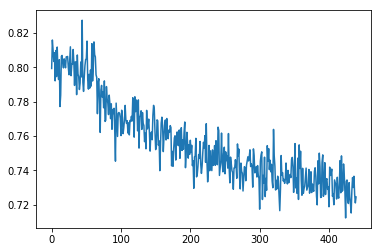

In [7]:
plt.plot(loss)

### Difference noise_type global, ped

In [66]:
encoder = Encoder()
encoded = encoder(xy_in)
encoded = encoded.view(-1, encoder.h_dim)

#### global

In [67]:
noise_shape = (seq_start_end.size(0),) + (8, 7, )
print(f'Noise shape: {noise_shape}')
z_decoder = get_noise(noise_shape, 'gaussian')
_list = []
for idx, (start, end) in enumerate(seq_start_end):
    start = start.item()
    end = end.item()
    _vec = z_decoder[idx].view(1, -1)
    _to_cat = _vec.repeat(end - start, 1)
    _list.append(torch.cat([encoded[start:end], _to_cat], dim=1))
decoder_h = torch.cat(_list, dim=0)

Noise shape: (64, 8, 7)


In [69]:
decoder_h[0:3][:, 64::]

tensor([[-1.7836,  0.9972, -1.7607,  1.1751,  0.0825, -1.4931, -0.9808,  1.5687,
         -0.7525, -0.6389,  1.7718, -0.0359,  0.7348, -2.0674,  1.3416, -0.3121,
         -2.1940, -0.3726,  2.0887,  1.1135,  0.4792,  0.0246,  0.2561,  1.2727,
          0.0332,  0.1422, -1.2312,  1.5383,  0.3047, -0.7562,  1.4335, -0.5552,
         -0.6846,  0.3327, -0.3120,  0.1599,  0.6174,  1.0967, -1.8389,  1.2277,
         -1.0982, -2.3356, -0.5044,  0.1160, -0.2551,  0.3992, -2.4658, -0.1071,
         -0.4886, -0.7834,  1.1696, -0.8476, -0.4626,  0.4979,  0.6687,  0.5181],
        [-1.7836,  0.9972, -1.7607,  1.1751,  0.0825, -1.4931, -0.9808,  1.5687,
         -0.7525, -0.6389,  1.7718, -0.0359,  0.7348, -2.0674,  1.3416, -0.3121,
         -2.1940, -0.3726,  2.0887,  1.1135,  0.4792,  0.0246,  0.2561,  1.2727,
          0.0332,  0.1422, -1.2312,  1.5383,  0.3047, -0.7562,  1.4335, -0.5552,
         -0.6846,  0.3327, -0.3120,  0.1599,  0.6174,  1.0967, -1.8389,  1.2277,
         -1.0982, -2.3356, 

#### ped

In [39]:
noise_shape = (encoded.size(0),) + (8, )
print(f'Noise shape: {noise_shape}')
z_decoder = get_noise(noise_shape, 'gaussian')
decoder_h = torch.cat([encoded, z_decoder], dim=1)

Noise shape: (165, 8)


In [47]:
decoder_h[0:3][:, 64::]

tensor([[-0.3827, -1.4266, -1.3999, -0.0565, -0.4766, -0.1560,  0.7794, -2.3886],
        [ 0.3209, -0.6869,  1.6386,  0.8475, -0.1990,  0.2208, -1.3008,  1.2482],
        [-0.8666, -1.1748,  1.3058, -1.8034, -0.7433, -0.9711,  1.9598, -2.1592]],
       grad_fn=<SliceBackward>)

In [53]:
z_dim = 8
bencoder = BicycleEncoder()
z_random = bencoder.get_z_random(xy_in.size(1), z_dim)

In [72]:
encoder.train??

In [9]:
class A:
    def __init__(self, x):
        self.x = x
        
    def ttest(self, y):
        self.x = y
        
    def test(self, y):
        x = self.x
        self.ttest(y)
        print(x)
        

In [11]:
b = A(25.25)

In [13]:
b.test(17)

25.25
